# Books Recommendation with RSVD and Collaborative Filtering

## Import library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset
import pickle, gzip, pickletools
from rsvd import RSVD

## Import dataset

In [2]:
df = pd.read_csv("./input/ratings.csv")
df

,user_id,book_id,rating
0,51e49f25-397d-43a1-a807-005933626d2e,1283,3
1,51e49f25-397d-43a1-a807-005933626d2e,11,3
2,51e49f25-397d-43a1-a807-005933626d2e,207,3
3,51e49f25-397d-43a1-a807-005933626d2e,312,3
4,51e49f25-397d-43a1-a807-005933626d2e,824,4
...,...,...,...
124836,b06db5a6-f1ca-4f2a-ab7f-90109157e4be,861,4
124837,b06db5a6-f1ca-4f2a-ab7f-90109157e4be,449,3
124838,b06db5a6-f1ca-4f2a-ab7f-90109157e4be,664,3
124839,b06db5a6-f1ca-4f2a-ab7f-90109157e4be,208,3


In [3]:
print(df["book_id"].unique().shape)

(886,)


## Split data

Split data into 80% training and 20% testing

In [4]:
trainset, testset = train_test_split(df, test_size=0.2)

print("Training set size: ", trainset.shape)
print("Test set size: ", testset.shape)

Training set size:  (99872, 3)
Test set size:  (24969, 3)


In [5]:
reader = Reader(line_format="user item rating", rating_scale=(1,5))
train_data = Dataset.load_from_df(trainset, reader)

In [6]:
train_data = train_data.build_full_trainset()

## Define MAE and RMSE as Evaluation Metric

In [7]:
def mae(testset, pred):
    if len(testset) != len(pred):
        raise ValueError("testset and pred must have the same length")

    n = len(testset)
    total_error = 0

    for i in range(n):
        total_error += abs(testset[i] - pred[i])

    return total_error / n

def rmse(testset, pred):
    if len(testset) != len(pred):
        raise ValueError("testset and pred must have the same length")


    test_arr = np.array(testset)
    pred_arr = np.array(pred)
    return np.sqrt(np.mean((pred-test_arr) ** 2))

## Train and Test Model

### Train RSVD model with reg = 0

In [8]:
mae_res = []
rmse_res = []
factors = []

for i in range(1, 8):
    print("train test", i)
    model_i = RSVD(n_factors=i, n_epochs=30, reg=0, verbose=False)
    model_i.fit(train_data)

    pred_test = model_i.predict(testset)

    mae_res.append(mae(testset["rating"].to_list(), pred_test))
    rmse_res.append(rmse(testset["rating"].to_list(), pred_test))
    factors.append(i)

result = pd.DataFrame({"latent features": factors, "MAE": mae_res, "RMSE": rmse_res})
result

train test 1
train test 2
train test 3
train test 4
train test 5
train test 6
train test 7


,latent features,MAE,RMSE
0,1,0.505586,0.712364
1,2,0.505208,0.711840
2,3,0.503116,0.710819
3,4,0.503043,0.710509
4,5,0.499382,0.706036
5,6,0.497261,0.705151
6,7,0.495355,0.703981


### Train RSVD model with reg = 0.05

In [9]:
mae_reg_res = []
rmse_reg_res = []
factors = []

for i in range(1, 8):
    print("train test", i)
    model_i = RSVD(n_factors=i, n_epochs=30, reg=0.05, verbose=False)
    model_i.fit(train_data)

    pred_test = model_i.predict(testset)

    mae_reg_res.append(mae(testset["rating"].to_list(), pred_test))
    rmse_reg_res.append(rmse(testset["rating"].to_list(), pred_test))
    factors.append(i)

result_reg = pd.DataFrame({"latent features": factors, "MAE": mae_reg_res, "RMSE": rmse_reg_res})
result_reg

train test 1
train test 2
train test 3
train test 4
train test 5
train test 6
train test 7


,latent features,MAE,RMSE
0,1,0.491471,0.697953
1,2,0.490817,0.697408
2,3,0.488067,0.694579
3,4,0.487785,0.694010
4,5,0.485906,0.693100
5,6,0.481956,0.689403
6,7,0.480496,0.687572


### Plot Result

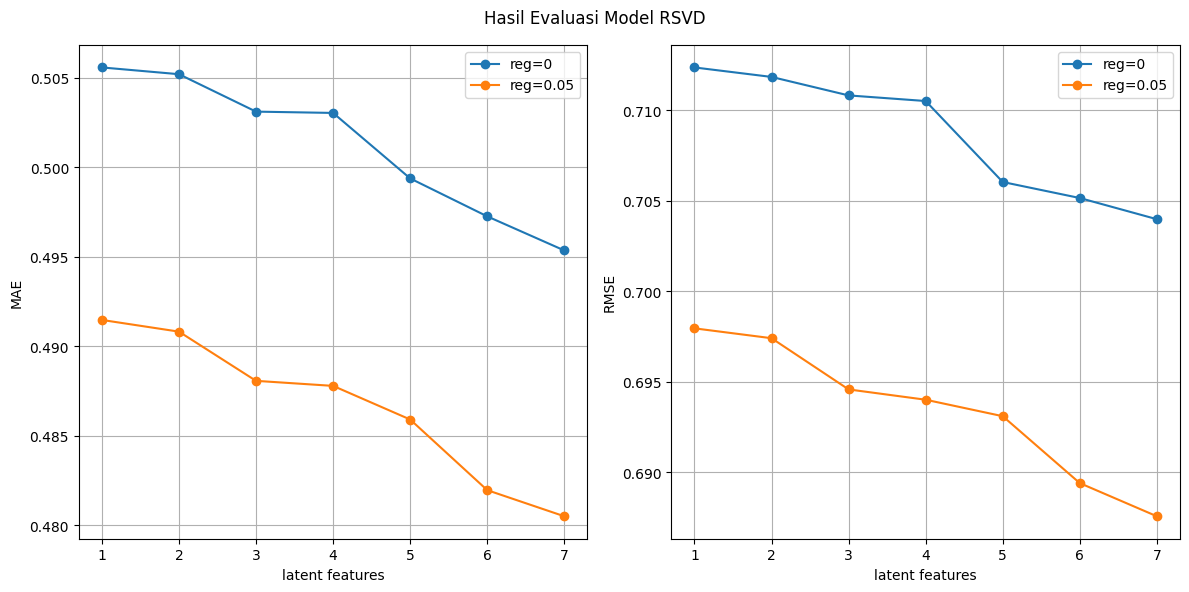

In [12]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))

# Left subplot for MAE
plt.subplot(1, 2, 1)
plt.plot(result["latent features"], result["MAE"], marker='o', label="reg=0")
plt.plot(result_reg["latent features"], result_reg["MAE"], marker='o', label="reg=0.05")

plt.legend(loc='upper right')
plt.xlabel('latent features')
plt.ylabel('MAE')
plt.grid()

# Right subplot for RMSE
plt.subplot(1, 2, 2)
plt.plot(result["latent features"], result["RMSE"], marker='o', label="reg=0")
plt.plot(result_reg["latent features"], result_reg["RMSE"], marker='o', label="reg=0.05")

plt.legend(loc='upper right')
plt.xlabel('latent features')
plt.ylabel('RMSE')
plt.grid()

plt.suptitle("Hasil Evaluasi Model RSVD")
plt.tight_layout()
plt.show()

## Dumping model to file

In [56]:
model_rsvd = RSVD(n_factors=7, n_epochs=30, reg=0.05, verbose=False)
model_rsvd.fit(train_data)

with gzip.open("rsvd_model.pkl.gz", "wb") as f:
    pickled = pickle.dumps(model_rsvd)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)